In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import math

daily_train = pd.read_csv('../../Datasets\Daily-train.csv')
daily_test = pd.read_csv('../../Datasets\Daily-test.csv')

__Selecting the Time Series Data for Our Predictions__

In [40]:
df = daily_train.transpose() # The data we train the model
test = daily_test.transpose() # The last actual values which we try to predict

df = df[0]
df = df.iloc[1:]
df = df.dropna()
new_index = pd.RangeIndex(start=0, stop=len(df))
df.index = new_index

test = test[0]
test = test.iloc[1:]
df = df.reset_index(drop=True)
test = test.reset_index(drop=True)
new_index = pd.RangeIndex(start=len(df), stop=len(df) + len(test))
test.index = new_index

# Connect all dataset train(df) and test data
Series = pd.concat([df, test], axis=0)
Series1 = pd.concat([df, test], axis=1, keys=['Train', 'Test'])

## Feature Engineering

__Time Series Decomposition: Additive Seasonal Decomposition__

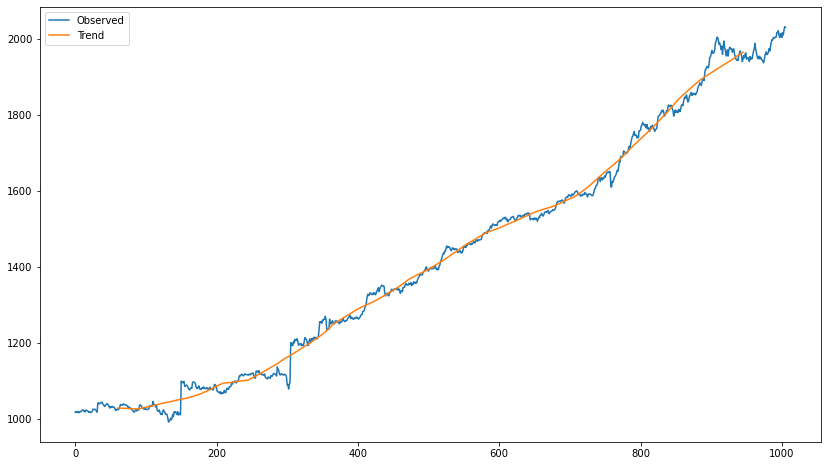

In [26]:
decomp = seasonal_decompose(df, model='additive', period=120)
observed = decomp.observed
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid
data = pd.concat([observed, trend, seasonal, residual], axis=1)
data.columns = ['observed', 'trend', 'seasonal', 'residual']

# Plot the data
fig, axes = plt.subplots(figsize=(14, 8))
data.observed.plot(ax=axes, label='Observed')
data.trend.plot(ax=axes, label='Trend')
axes.legend()
plt.show()

__Fixed the Null Values in the Trend Component with Additive Holt's Exponential Smoothing__

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


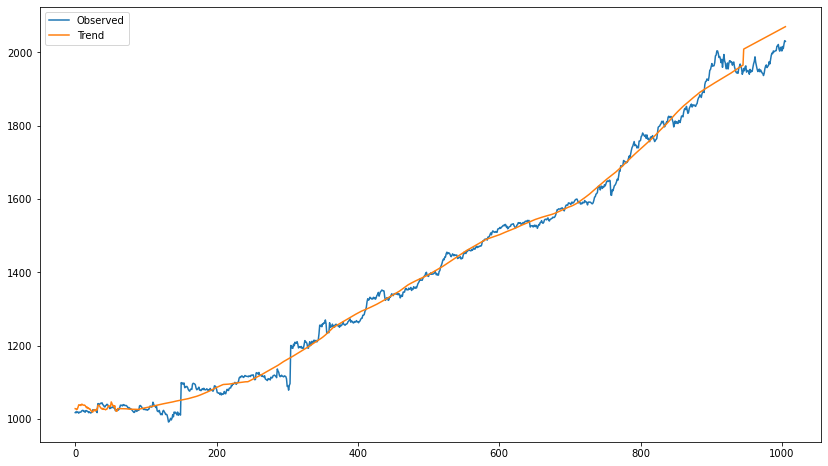

In [27]:
# Identify the indices of null values in the trend component
null_indices = trend.isnull()

# Perform exponential smoothing to fill null values in the trend component
model = ExponentialSmoothing(observed[~null_indices], trend='add', seasonal=None)
fitted_model = model.fit()
trend_filled = fitted_model.predict(start=0, end=len(trend)-1)

# Replace the null values in the original trend with the smoothed values
trend[null_indices] = trend_filled[null_indices]

# Concatenate the components into a DataFrame
data = pd.concat([observed, trend, seasonal, residual], axis=1)
data.columns = ['observed', 'trend', 'seasonal', 'residual']


# Plot the data
fig, axes = plt.subplots(figsize=(14, 8))
data.observed.plot(ax=axes, label='Observed')
data.trend.plot(ax=axes, label='Trend')
axes.legend()
plt.show()


In [28]:
data.isna().sum()

observed      0
trend         0
seasonal      0
residual    120
dtype: int64

## Prepare the Data

In [ ]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(data[['observed', 'trend']])

df_train, df_test = scaled_df[:int(len(scaled_df)*0.8)], scaled_df[int(len(scaled_df)*0.8):]

window_size = 7
step =1

def create_sequences(df, window_size, step):
    X = []
    y = []

    for i in range(window_size, len(df)):
        X.append(df[i-window_size:i, :])  # Include all features in the window
        y.append(df[i, 0])  # Assuming 'Values' column is the target

    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = create_sequences(df_train, window_size, step)
X_test, y_test = create_sequences(df_test, window_size, step)

In [ ]:
def forecasting_with_n_features(model, num_forecast, window_size, n_features):
    # Reshape the last sequence in X_test for forecasting
    X_forecast = np.reshape(X_test[-1], (1, window_size, n_features))

    # Generate the forecasts
    Forecast_actual = []  # List to store predicted actual values
    Forecast_trend = []   # List to store predicted trend values

    for _ in range(num_forecast):
        # Predict both actual and trend values
        next_actual, next_trend = model.predict(X_forecast)[0]  # Get the next predicted values

        Forecast_actual.append(next_actual)
        Forecast_trend.append(next_trend)

        # Update X_forecast for the next prediction
        X_forecast = np.roll(X_forecast, -1, axis=1)
        X_forecast[0, -1, 0] = next_actual  # Update the last value in the sequence with the predicted actual value
        X_forecast[0, -1, 1] = next_trend   # Update the last value in the sequence with the predicted trend value

    # Convert lists to NumPy arrays
    Forecast_actual = np.array(Forecast_actual)
    Forecast_trend = np.array(Forecast_trend)

    # Perform inverse transformation on the forecasted data for both actual and trend
    Forecast_actual = Forecast_actual.reshape(-1, 1)
    Forecast_trend = Forecast_trend.reshape(-1, 1)

    # Concatenate the Forecast arrays with zero-filled arrays to match the desired shape
    Forecast_actual = np.concatenate((Forecast_actual, np.zeros((num_forecast, n_features-1))), axis=1)
    Forecast_trend = np.concatenate((Forecast_trend, np.zeros((num_forecast, n_features-1))), axis=1)

    # Apply the inverse_transform function from the scaler object to the concatenated arrays for both actual and trend
    Forecast_actual = scaler.inverse_transform(Forecast_actual)
    Forecast_trend = scaler.inverse_transform(Forecast_trend)

    # Select only the first column of the transformed arrays using [:, 0] indexing for both actual and trend
    Forecast_actual = Forecast_actual[:, 0]
    Forecast_trend = Forecast_trend[:, 0]

    # Print the forecasts
    if num_forecast == len(test):
        print("Forecasts:")
        for i in range(num_forecast):
            if i < 9:
                print(f"Predicted Actual {i+1}: {round(float(Forecast_actual[i]), 1)} | Predicted Trend {i+1}: {round(float(Forecast_trend[i]), 1)} | The Actual value: {test.iloc[i]}")
            else:
                print(f"Predicted Actual {i+1}: {round(float(Forecast_actual[i]), 1)} | Predicted Trend {i+1}: {round(float(Forecast_trend[i]), 1)} | The Actual value: {test.iloc[i]}")

    return Forecast_actual, Forecast_trend

# Call the modified forecasting function
Forecast_actual, Forecast_trend = forecasting_with_n_features(model, len(test), window_size, n_features)


__Create the First Model__

In [30]:
model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mse')
#callbacks= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=14)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Epoch 1/100
25/25 [==============================] - 1s 14ms/step - loss: 0.0317 - val_loss: 0.0349
Epoch 2/100
25/25 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0255
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0132
Epoch 4/100
25/25 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0229
Epoch 5/100
25/25 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0145
Epoch 6/100
25/25 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0220
Epoch 7/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0123
Epoch 8/100
25/25 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0077
Epoch 9/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0122
Epoch 10/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0093
Epoch 11

__Create the Second Model__

In [31]:
# Create the model
model1 = Sequential()
model1.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(LSTM(64))
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(8, activation='relu'))
model1.add(Dense(1, activation='linear'))

model1.compile(loss='mse', optimizer=Adam(learning_rate=0.00001))
#callbacks= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=14)
history1 = model1.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=250)

Epoch 1/250
25/25 [==============================] - 7s 65ms/step - loss: 0.1333 - val_loss: 0.7465
Epoch 2/250
25/25 [==============================] - 0s 15ms/step - loss: 0.1292 - val_loss: 0.7204
Epoch 3/250
25/25 [==============================] - 0s 14ms/step - loss: 0.1235 - val_loss: 0.6951
Epoch 4/250
25/25 [==============================] - 0s 14ms/step - loss: 0.1181 - val_loss: 0.6700
Epoch 5/250
25/25 [==============================] - 0s 14ms/step - loss: 0.1125 - val_loss: 0.6446
Epoch 6/250
25/25 [==============================] - 0s 15ms/step - loss: 0.1070 - val_loss: 0.6203
Epoch 7/250
25/25 [==============================] - 0s 13ms/step - loss: 0.1020 - val_loss: 0.5969
Epoch 8/250
25/25 [==============================] - 0s 14ms/step - loss: 0.0987 - val_loss: 0.5765
Epoch 9/250
25/25 [==============================] - 0s 13ms/step - loss: 0.0941 - val_loss: 0.5576
Epoch 10/250
25/25 [==============================] - 0s 14ms/step - loss: 0.0925 - val_loss: 0.5390

__Comparing Training and Validation Loss: SimpleRNN vs LSTM__

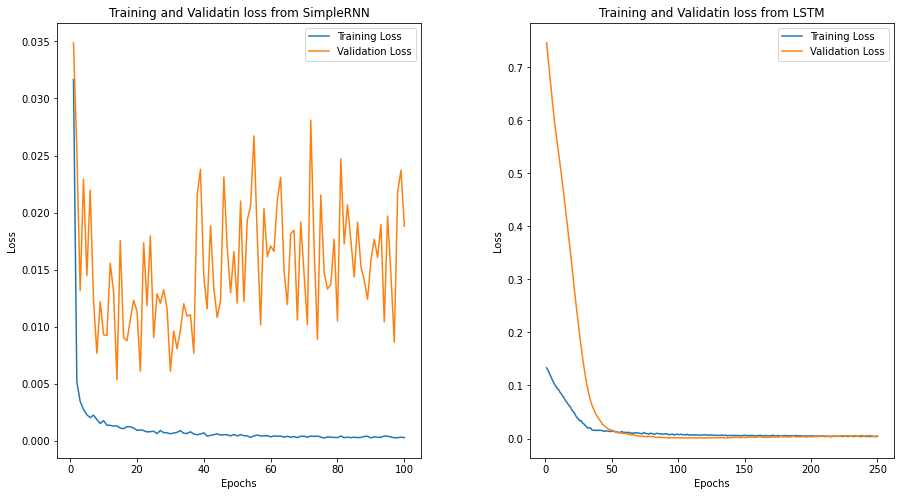

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
epochs1 = range(1, len(loss1)+1)

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].plot(epochs, loss, label='Training Loss')
ax[0].plot(epochs, val_loss, label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Validatin loss from SimpleRNN')
ax[0].legend()

ax[1].plot(epochs1, loss1, label='Training Loss')
ax[1].plot(epochs1, val_loss1, label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Training and Validatin loss from LSTM')
ax[1].legend()

plt.subplots_adjust(wspace=0.3)

plt.show()

__Multivariate Multistep Time Series Forecasting__

In [33]:
n_features = X_train.shape[2]
num_forecast = 14

def forecasting_with_n_features(model, num_forecast, window_size, n_features, observed_trend_sequence):
    # Reshape the last sequence in X_test for forecasting
    X_forecast = np.reshape(observed_trend_sequence, (1, window_size, n_features))

    # Generate the forecasts
    Forecast = []
    for _ in range(num_forecast):
        next_value = model.predict(X_forecast)  # Get the next predicted value
        Forecast.append(next_value)

        # Update X_forecast for the next prediction
        X_forecast = np.roll(X_forecast, -1, axis=1)
        X_forecast[0, -1, 0] = next_value  # Update the last value in the sequence with the predicted value

    Forecast = np.array(Forecast)
    Forecast = Forecast.reshape(-1, 1)  # Reshape to (num_forecast, 1)

    # Perform inverse transformation on the forecasted data
    # Concatenate the Forecast array with a zero-filled array to match the desired shape
    Forecast = np.concatenate((Forecast, np.zeros((num_forecast, n_features-1))), axis=1)

    # Apply the inverse_transform function from the scaler object to the concatenated array
    Forecast = scaler.inverse_transform(Forecast)

    # Select only the first column of the transformed array using [:, 0] indexing
    Forecast = Forecast[:, 0]

   # Print the forecasts
    if num_forecast == len(test):
        print("Forecasts:")
        for i, forecast in enumerate(Forecast):
            if i < 9:
                print(f"Predicted Price {i+1}: {round(float(forecast), 1)}", '   |  The Actual value:', test.iloc[i])
            else:
                print(f"Predicted Price {i+1}: {round(float(forecast), 1)}", '  |  The Actual value:', test.iloc[i])

    return Forecast

In [ ]:
forecasting_with_n_features(model, num_forecast, window_size, n_features, observed_trend_sequence)

In [34]:
n_features = X_train.shape[2]
num_forecast = 14

def forecasting_with_n_features(model, num_forecast, window_size, n_features):
    # Reshape the last sequence in X_test for forecasting
    X_forecast = np.reshape(X_test[-1], (1, window_size, n_features))

    # Generate the forecasts
    Forecast = []
    for _ in range(num_forecast):
        next_value = model.predict(X_forecast)  # Get the next predicted value
        Forecast.append(next_value)

        # Update X_forecast for the next prediction
        X_forecast = np.roll(X_forecast, -1, axis=1)
        X_forecast[0, -1, 0] = next_value  # Update the last value in the sequence with the predicted value

    Forecast = np.array(Forecast)
    Forecast = Forecast.reshape(-1, 1)  # Reshape to (num_forecast, 1)

    # Perform inverse transformation on the forecasted data
    # Concatenate the Forecast array with a zero-filled array to match the desired shape
    Forecast = np.concatenate((Forecast, np.zeros((num_forecast, n_features-1))), axis=1)

    # Apply the inverse_transform function from the scaler object to the concatenated array
    Forecast = scaler.inverse_transform(Forecast)

    # Select only the first column of the transformed array using [:, 0] indexing
    Forecast = Forecast[:, 0]

   # Print the forecasts
    if num_forecast == len(test):
        print("Forecasts:")
        for i, forecast in enumerate(Forecast):
            if i < 9:
                print(f"Predicted Price {i+1}: {round(float(forecast), 1)}", '   |  The Actual value:', test.iloc[i])
            else:
                print(f"Predicted Price {i+1}: {round(float(forecast), 1)}", '  |  The Actual value:', test.iloc[i])

    return Forecast

In [35]:
Forc_mod = forecasting_with_n_features(model, len(test), window_size, n_features)

1/1 [==============================] - 0s 29ms/step


C:\Users\User\AppData\Local\Temp\ipykernel_11272\3598357629.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_forecast[0, -1, 0] = next_value  # Update the last value in the sequence with the predicted value


1/1 [==============================] - 0s 31ms/step
Forecasts:
Predicted Price 1: 1017.4    |  The Actual value: 2039.2
Predicted Price 2: 1021.6    |  The Actual value: 2035.0
Predicted Price 3: 1025.1    |  The Actual value: 2051.8
Predicted Price 4: 1026.4    |  The Actual value: 2061.8
Predicted Price 5: 1027.2    |  The Actual value: 2063.5
Predicted Price 6: 1027.9    |  The Actual value: 2069.5
Predicted Price 7: 1027.9    |  The Actual value: 2054.0
Predicted Price 8: 1028.0    |  The Actual value: 2057.0
Predicted Price 9: 1028.1    |  The Actual value: 2062.8
Predicted Price 10: 1028.1   |  The Actual value: 2066.4
Predicted Price 11: 1028.1   |  The Actual value: 2067.4
Predicted Price 12: 1028.1   |  The Actual value: 2071.4
Predicted Price 13: 1028.1   |  The Actual value: 2083.8
Predicted Price 14: 1028.1   |  The Actual value: 2080.6


In [36]:
Forc_mod1 = forecasting_with_n_features(model1, len(test), window_size, n_features)

1/1 [==============================] - 0s 33ms/step


C:\Users\User\AppData\Local\Temp\ipykernel_11272\3598357629.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_forecast[0, -1, 0] = next_value  # Update the last value in the sequence with the predicted value


1/1 [==============================] - 0s 30ms/step
Forecasts:
Predicted Price 1: 1024.4    |  The Actual value: 2039.2
Predicted Price 2: 1024.6    |  The Actual value: 2035.0
Predicted Price 3: 1025.0    |  The Actual value: 2051.8
Predicted Price 4: 1025.7    |  The Actual value: 2061.8
Predicted Price 5: 1026.7    |  The Actual value: 2063.5
Predicted Price 6: 1028.0    |  The Actual value: 2069.5
Predicted Price 7: 1029.5    |  The Actual value: 2054.0
Predicted Price 8: 1031.2    |  The Actual value: 2057.0
Predicted Price 9: 1031.4    |  The Actual value: 2062.8
Predicted Price 10: 1031.6   |  The Actual value: 2066.4
Predicted Price 11: 1031.8   |  The Actual value: 2067.4
Predicted Price 12: 1032.1   |  The Actual value: 2071.4
Predicted Price 13: 1032.3   |  The Actual value: 2083.8
Predicted Price 14: 1032.5   |  The Actual value: 2080.6


__Visualizing Multistep Forecasting for Our Two Models__

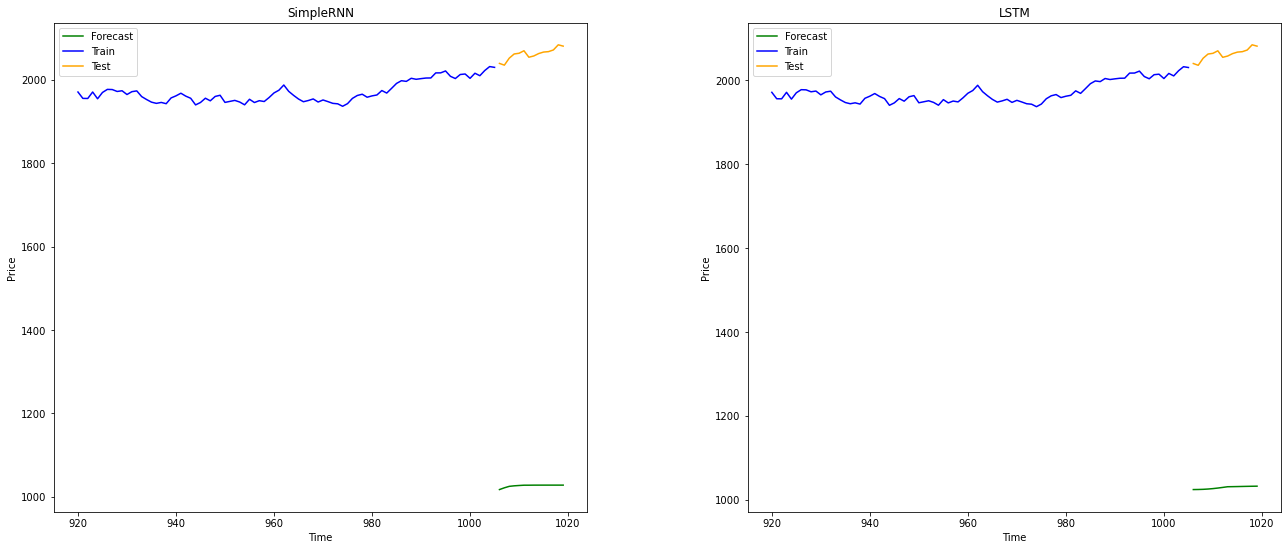

In [37]:
# SimpleRNN Model
Forc_mod = pd.DataFrame(Forc_mod)
Forc_mod = Forc_mod.reset_index(drop=True)
new_index = pd.RangeIndex(start=len(df), stop= len(df) + len(Forc_mod))
Forc_mod.index = new_index

# LSTM Model
Forc_mod1 = pd.DataFrame(Forc_mod1)
Forc_mod1 = Forc_mod1.reset_index(drop=True)
Forc_mod1.index = new_index

fig, axs = plt.subplots(1, 2, figsize=(22, 9))

# Plotting the SimpleRNN.
axs[0].plot(Forc_mod.tail(100), label='Forecast', color='green')
axs[0].plot(Series1.Train.tail(100), label='Train', color='blue')
axs[0].plot(Series1.Test.tail(100), label='Test', color='orange')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Price')
axs[0].set_title('SimpleRNN')
axs[0].legend()

# Plotting the LSTM.
axs[1].plot(Forc_mod1.tail(100), label='Forecast', color='green')
axs[1].plot(Series1.Train.tail(100), label='Train', color='blue')
axs[1].plot(Series1.Test.tail(100), label='Test', color='orange')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Price')
axs[1].set_title('LSTM')
axs[1].legend()

plt.subplots_adjust(wspace=0.3)
plt.show()

__Conclusion:__<br><br>
**When we compared two models for predicting time series data, the LSTM model stood out as the better option. It performed more accurately and could generalize well, avoiding the problem of overfitting seen in the SimpleRNN model. While the LSTM model isn't perfect and might still have some small errors, it's a strong choice for time series forecasting tasks.**